In [41]:
import pickle
import pandas as pd
import xgboost as xgb
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score

# Load dataset
with open("train_val_test_1.pkl", "rb") as f:
    X_train, X_val, X_test, y_train, y_val, y_test = pickle.load(f)

print("Data successfully loaded!")


Data successfully loaded!


In [42]:
# Convert categorical features to category dtype for XGBoost
categorical_features = ["purpose", "emp_length"]
for col in categorical_features:
    X_train[col] = X_train[col].astype("category")
    X_val[col] = X_val[col].astype("category")
    X_test[col] = X_test[col].astype("category")

print("Categorical processing complete.")


Categorical processing complete.


In [43]:
print(X_train.dtypes.to_string())


acc_open_past_24mths           float64
all_util                       float64
annual_inc                     float64
application_type                 int64
avg_cur_bal                    float64
bc_open_to_buy                 float64
bc_util                        float64
dti                            float64
delinq_2yrs                    float64
emp_length                    category
fico_range_high                float64
fico_range_low                 float64
il_util                        float32
inq_fi                         float32
inq_last_12m                   float32
inq_last_6mths                 float64
installment                    float64
int_rate                       float64
loan_amnt                      float64
max_bal_bc                     float32
mo_sin_old_il_acct             float64
mo_sin_old_rev_tl_op           float64
mo_sin_rcnt_rev_tl_op          float64
mo_sin_rcnt_tl                 float64
mort_acc                       float64
mths_since_rcnt_il       

In [44]:
import xgboost as xgb

# Change different parameters
# Plot cross-validation results

evals_result = {}  # Dictionary to store results
# Initialize XGBoost classifier
xgb_model = xgb.XGBClassifier(
    objective="multi:softmax",  # Multi-class classification
    num_class=len(y_train.unique()),  # Number of unique classes
    tree_method="hist",  # Faster training
    enable_categorical=True,  # Use categorical support
    use_label_encoder=False,
    eval_metric=["mlogloss", "merror", "auc"]  # Move eval_metric here
                            # AUC (Choose other ranking metics)
)

# Train the model with early stopping
xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],  # Validation set
     
    
)

print("Model training complete.")


[0]	validation_0-mlogloss:0.54134	validation_0-merror:0.12615	validation_0-auc:0.73262


/Users/jiaxuanliu/anaconda3/envs/math170/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [13:09:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[1]	validation_0-mlogloss:0.45994	validation_0-merror:0.12628	validation_0-auc:0.74129
[2]	validation_0-mlogloss:0.41256	validation_0-merror:0.12615	validation_0-auc:0.74320
[3]	validation_0-mlogloss:0.38353	validation_0-merror:0.12615	validation_0-auc:0.74381
[4]	validation_0-mlogloss:0.36523	validation_0-merror:0.12610	validation_0-auc:0.74577
[5]	validation_0-mlogloss:0.35377	validation_0-merror:0.12611	validation_0-auc:0.74744
[6]	validation_0-mlogloss:0.34630	validation_0-merror:0.12604	validation_0-auc:0.74940
[7]	validation_0-mlogloss:0.34177	validation_0-merror:0.12602	validation_0-auc:0.75028
[8]	validation_0-mlogloss:0.33859	validation_0-merror:0.12596	validation_0-auc:0.75123
[9]	validation_0-mlogloss:0.33654	validation_0-merror:0.12598	validation_0-auc:0.75222
[10]	validation_0-mlogloss:0.33518	validation_0-merror:0.12596	validation_0-auc:0.75313
[11]	validation_0-mlogloss:0.33413	validation_0-merror:0.12592	validation_0-auc:0.75379
[12]	validation_0-mlogloss:0.33331	valida

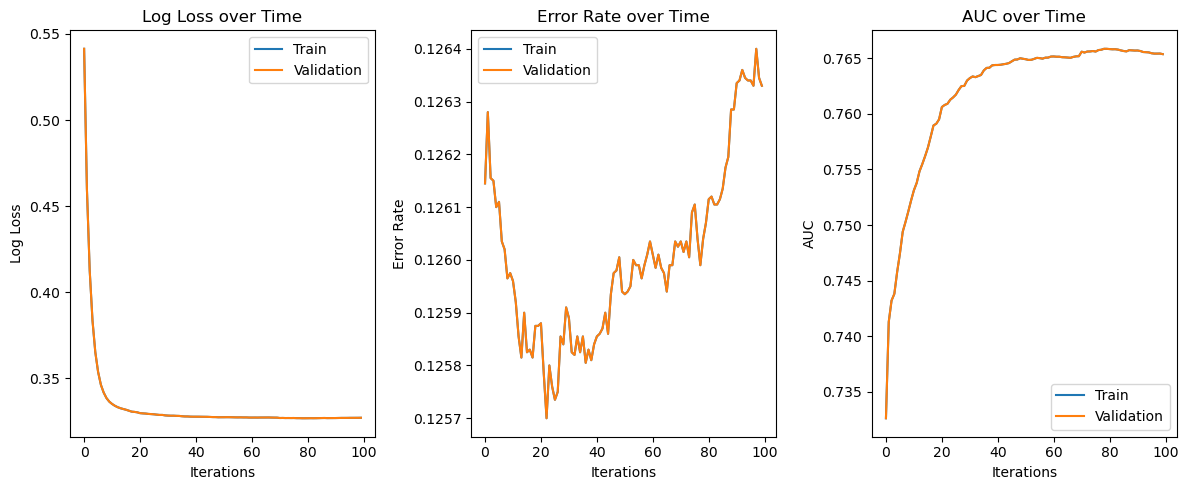

In [46]:
## Plot learning Curve
import matplotlib.pyplot as plt

# Extract evaluation results
results = xgb_model.evals_result()

# Define figure size
plt.figure(figsize=(12, 5))

# Plot Log Loss (mlogloss)
plt.subplot(1, 3, 1)
plt.plot(results["validation_0"]["mlogloss"], label="Train")
plt.plot(results["validation_0"]["mlogloss"], label="Validation")
plt.xlabel("Iterations")
plt.ylabel("Log Loss")
plt.title("Log Loss over Time")
plt.legend()

# Plot Error Rate (merror)
plt.subplot(1, 3, 2)
plt.plot(results["validation_0"]["merror"], label="Train")
plt.plot(results["validation_0"]["merror"], label="Validation")
plt.xlabel("Iterations")
plt.ylabel("Error Rate")
plt.title("Error Rate over Time")
plt.legend()

# Plot AUC (auc)
plt.subplot(1, 3, 3)
plt.plot(results["validation_0"]["auc"], label="Train")
plt.plot(results["validation_0"]["auc"], label="Validation")
plt.xlabel("Iterations")
plt.ylabel("AUC")
plt.title("AUC over Time")
plt.legend()

# Show plots
plt.tight_layout()
plt.show()


## Interpretation

### 1. Log Loss: 
Observation: Both the training and validation log loss decrease rapidly at the beginning and plateau around iteration 30. 

Interpretation: \
The model is converging well, as log loss is decreasing and stabilizing. \
There is no major overfitting since training and validation curves are closely aligned. \
A stable log loss means the model is confident in its predictions.

### 2. Error Rate
Observation: The validation error rate initially drops but then fluctuates after about 40 iterations. 

Interpretation: \
The model is improving in the beginning, but later, the validation error starts to increase slightly. \
This could indicate overfitting, meaning the model is learning patterns in the training data that do not generalize well. \
If error rate keeps increasing, early stopping (already used) is a good safeguard.

### 3. AUC
Observation: The validation AUC increases initially, peaks, and then starts slightly decreasing after ~60 iterations.

Interpretation: \
AUC increasing at first is good—it means the model is improving. \
The drop in AUC after a peak suggests the model is starting to overfit. \
Early stopping is preventing excessive overfitting, but tuning regularization (lambda, alpha) could help.

In [47]:
from sklearn.metrics import accuracy_score, log_loss

# Make predictions on training and test sets
y_train_pred = xgb_model.predict(X_train)  # Predictions on training set
y_test_pred = xgb_model.predict(X_test)  # Predictions on test set

# Compute training and test accuracy
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

# Compute training and test log loss
train_log_loss = log_loss(y_train, xgb_model.predict_proba(X_train))
test_log_loss = log_loss(y_test, xgb_model.predict_proba(X_test))

# Print results
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Training Log Loss: {train_log_loss:.4f}")
print(f"Test Log Loss: {test_log_loss:.4f}")


Training Accuracy: 0.8787
Test Accuracy: 0.8755
Training Log Loss: 0.3055
Test Log Loss: 0.3248


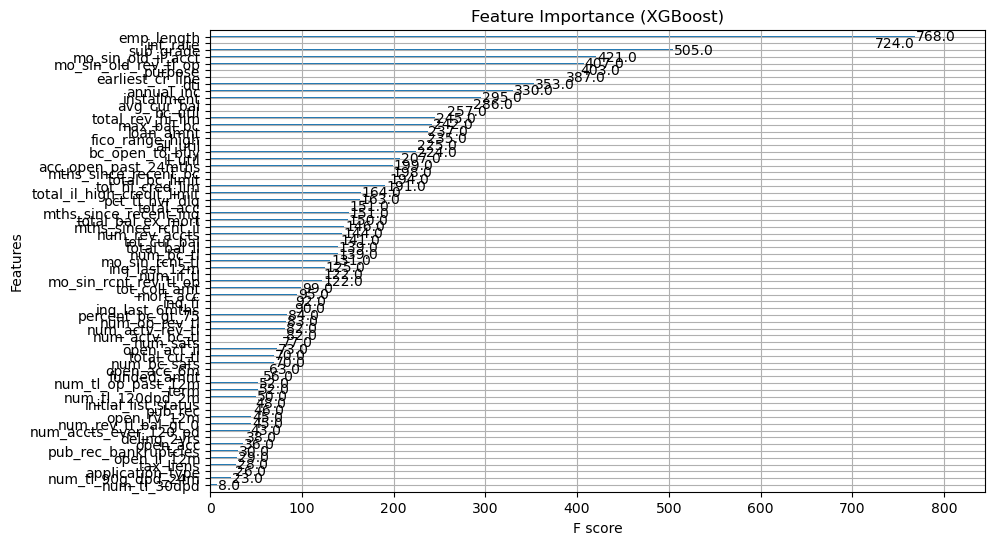

In [48]:
# Feature Importance
import matplotlib.pyplot as plt
import xgboost as xgb

# Plot feature importance
fig, ax = plt.subplots(figsize=(10, 6))
xgb.plot_importance(xgb_model, importance_type="weight", ax=ax)
plt.title("Feature Importance (XGBoost)")
plt.show()

In [49]:
# Get feature importance scores
feature_importance = xgb_model.get_booster().get_score(importance_type="weight")

# Convert to DataFrame for better readability
importance_df = pd.DataFrame(
    feature_importance.items(),
    columns=["Feature", "Importance"]
).sort_values(by="Importance", ascending=False)

print(importance_df.to_string())

                       Feature  Importance
9                   emp_length       768.0
16                    int_rate       724.0
53                   sub_grade       505.0
19          mo_sin_old_il_acct       421.0
20        mo_sin_old_rev_tl_op       407.0
57                     purpose       403.0
60            earliest_cr_line       387.0
7                          dti       353.0
2                   annual_inc       330.0
15                 installment       295.0
4                  avg_cur_bal       286.0
6                      bc_util       257.0
59            total_rev_hi_lim       245.0
18                  max_bal_bc       242.0
17                   loan_amnt       237.0
10             fico_range_high       235.0
1                     all_util       225.0
5               bc_open_to_buy       224.0
11                     il_util       207.0
0         acc_open_past_24mths       199.0
25        mths_since_recent_bc       198.0
54              total_bc_limit       194.0
55         

## Improved Model Training

In [65]:
import xgboost as xgb
# Calculate class imbalance for proper weighting
class_counts = np.bincount(y_train)
print(f"Class distribution: {class_counts}")
# scale_pos_weight gives more weight to the minority class (defaults)
scale_pos_weight = class_counts[0] / class_counts[1]
print(f"Calculated scale_pos_weight: {scale_pos_weight:.2f}")

# Initialize XGBoost classifier with evaluation enabled
xgb_model = xgb.XGBClassifier(
    objective="multi:softmax",  
    num_class=len(y_train.unique()),  
    tree_method="hist",  
    enable_categorical=True,  
    use_label_encoder=False,  
    reg_alpha=5,  
    reg_lambda=2,  
    learning_rate=0.05,  
    max_depth=4,  
    min_child_weight=3,  
    n_estimators=500,  
    early_stopping_rounds=20,  
    eval_metric=["mlogloss", "merror", "auc"],
    scale_pos_weight=scale_pos_weight,
)

# ✅ Train the model with evaluation enabled
xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],  # Use train & validation set
    verbose=True  # Show progress
)

print("✅ Model training complete with evaluation results.")


Class distribution: [ 75387 524613]
Calculated scale_pos_weight: 0.14
[0]	validation_0-mlogloss:0.66441	validation_0-merror:0.12565	validation_0-auc:0.70747	validation_1-mlogloss:0.66445	validation_1-merror:0.12608	validation_1-auc:0.70320


/Users/jiaxuanliu/anaconda3/envs/math170/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [22:15:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[1]	validation_0-mlogloss:0.63841	validation_0-merror:0.12565	validation_0-auc:0.71677	validation_1-mlogloss:0.63850	validation_1-merror:0.12608	validation_1-auc:0.71291
[2]	validation_0-mlogloss:0.61472	validation_0-merror:0.12565	validation_0-auc:0.72369	validation_1-mlogloss:0.61485	validation_1-merror:0.12608	validation_1-auc:0.72015
[3]	validation_0-mlogloss:0.59329	validation_0-merror:0.12565	validation_0-auc:0.72340	validation_1-mlogloss:0.59345	validation_1-merror:0.12608	validation_1-auc:0.71998
[4]	validation_0-mlogloss:0.57365	validation_0-merror:0.12565	validation_0-auc:0.72518	validation_1-mlogloss:0.57385	validation_1-merror:0.12608	validation_1-auc:0.72200
[5]	validation_0-mlogloss:0.55567	validation_0-merror:0.12565	validation_0-auc:0.72623	validation_1-mlogloss:0.55590	validation_1-merror:0.12608	validation_1-auc:0.72323
[6]	validation_0-mlogloss:0.53923	validation_0-merror:0.12565	validation_0-auc:0.72666	validation_1-mlogloss:0.53950	validation_1-merror:0.12608	valid

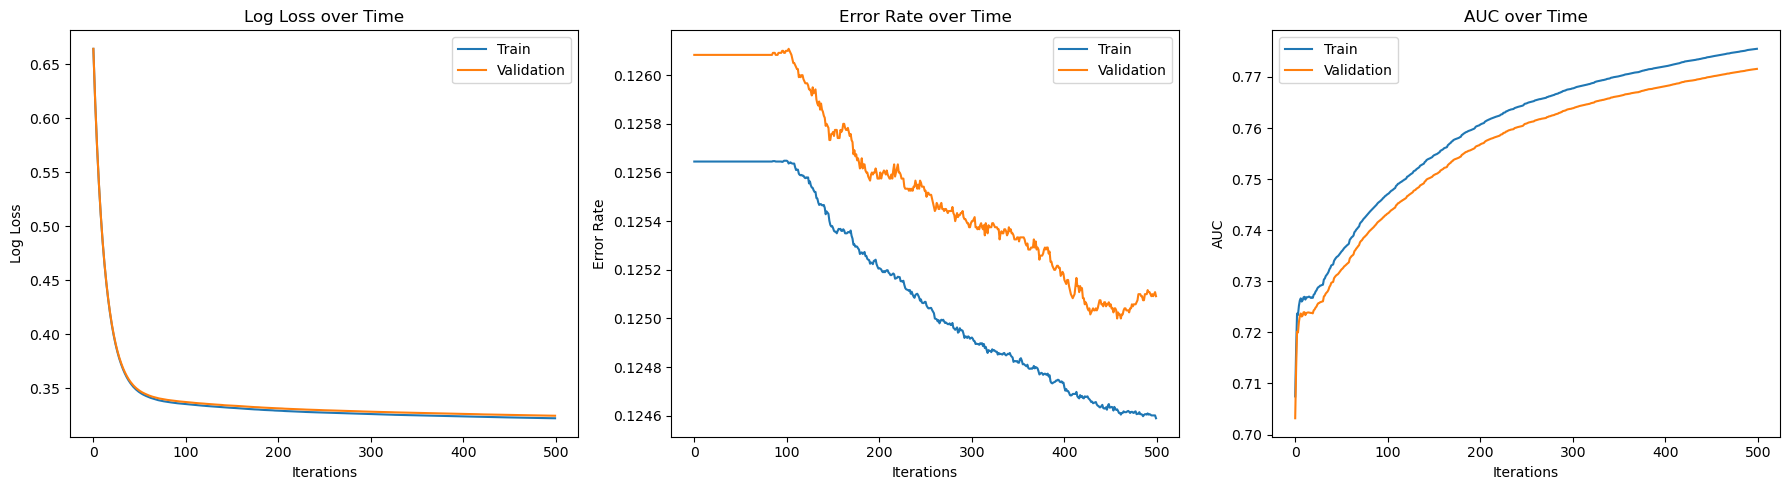

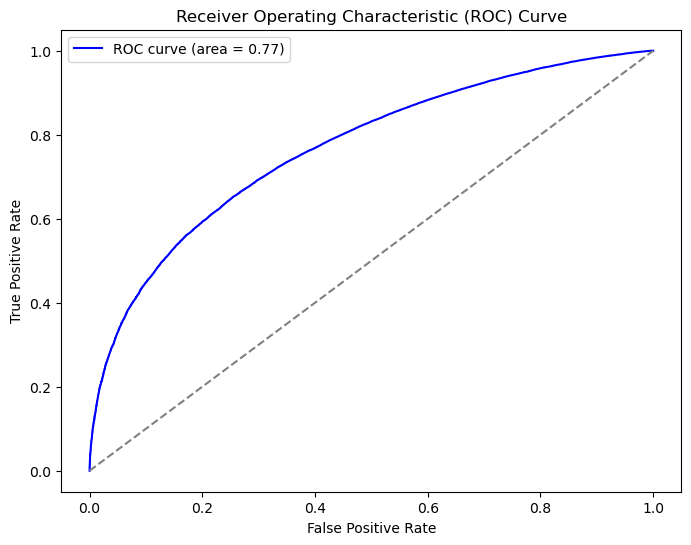

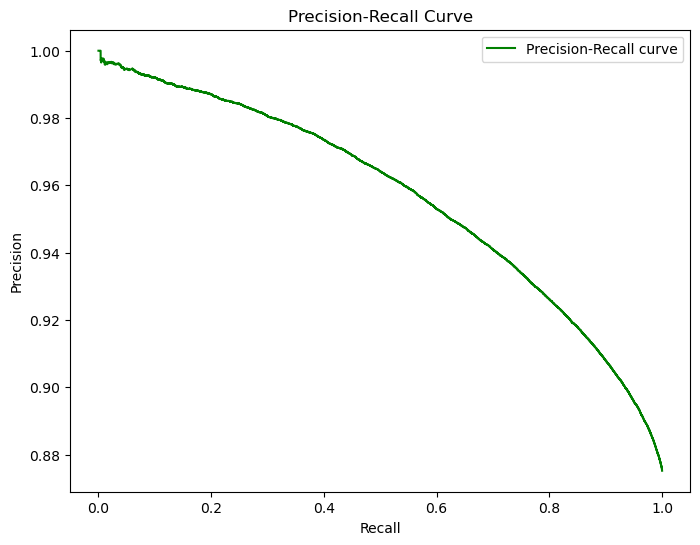

In [67]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import numpy as np

# Retrieve evaluation history
results = xgb_model.evals_result()

# Extract epochs
epochs = len(results["validation_1"]["mlogloss"])  # Use validation set
x_axis = range(0, epochs)

# Create figure with 3 subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Plot Log Loss
axs[0].plot(x_axis, results["validation_0"]["mlogloss"], label="Train")
axs[0].plot(x_axis, results["validation_1"]["mlogloss"], label="Validation")
axs[0].set_title("Log Loss over Time")
axs[0].set_xlabel("Iterations")
axs[0].set_ylabel("Log Loss")
axs[0].legend()

# Plot Error Rate
axs[1].plot(x_axis, results["validation_0"]["merror"], label="Train")
axs[1].plot(x_axis, results["validation_1"]["merror"], label="Validation")
axs[1].set_title("Error Rate over Time")
axs[1].set_xlabel("Iterations")
axs[1].set_ylabel("Error Rate")
axs[1].legend()

# Plot AUC
axs[2].plot(x_axis, results["validation_0"]["auc"], label="Train")
axs[2].plot(x_axis, results["validation_1"]["auc"], label="Validation")
axs[2].set_title("AUC over Time")
axs[2].set_xlabel("Iterations")
axs[2].set_ylabel("AUC")
axs[2].legend()

plt.tight_layout()
plt.show()

# Generate ROC Curve
y_pred_prob = xgb_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

# Generate Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='green', label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()


In [68]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Make predictions
y_train_pred = xgb_model.predict(X_train)
y_val_pred = xgb_model.predict(X_val)
y_test_pred = xgb_model.predict(X_test)

# Compute accuracy metrics
accuracy_train = accuracy_score(y_train, y_train_pred)
accuracy_val = accuracy_score(y_val, y_val_pred)
accuracy_test = accuracy_score(y_test, y_test_pred)

# Compute precision, recall, and F1-score for validation set
precision_val = precision_score(y_val, y_val_pred, average="weighted")
recall_val = recall_score(y_val, y_val_pred, average="weighted")
f1_val = f1_score(y_val, y_val_pred, average="weighted")

# Display results
accuracy_results = {
    "Train Accuracy": accuracy_train,
    "Validation Accuracy": accuracy_val,
    "Test Accuracy": accuracy_test,
    "Validation Precision": precision_val,
    "Validation Recall": recall_val,
    "Validation F1-score": f1_val
}

accuracy_results


{'Train Accuracy': 0.87541,
 'Validation Accuracy': 0.8749083333333333,
 'Test Accuracy': 0.875795,
 'Validation Precision': 0.8432338327286447,
 'Validation Recall': 0.8749083333333333,
 'Validation F1-score': 0.8205396842439364}

In [69]:
# Get feature importance scores
feature_importance = xgb_model.get_booster().get_score(importance_type="weight")

# Convert to DataFrame for better readability
importance_df = pd.DataFrame(
    feature_importance.items(),
    columns=["Feature", "Importance"]
).sort_values(by="Importance", ascending=False)

print(importance_df.to_string())

                       Feature  Importance
16                    int_rate      1699.0
53                   sub_grade      1483.0
60            earliest_cr_line       776.0
9                   emp_length       661.0
20        mo_sin_old_rev_tl_op       661.0
2                   annual_inc       437.0
19          mo_sin_old_il_acct       433.0
17                   loan_amnt       421.0
18                  max_bal_bc       404.0
7                          dti       389.0
0         acc_open_past_24mths       352.0
57                     purpose       331.0
15                 installment       316.0
54              total_bc_limit       290.0
6                      bc_util       268.0
1                     all_util       267.0
10             fico_range_high       263.0
59            total_rev_hi_lim       257.0
25        mths_since_recent_bc       222.0
65                 funded_amnt       212.0
55             tot_hi_cred_lim       209.0
4                  avg_cur_bal       196.0
24         